In [1]:
import random
import argparse
import numpy as np
import pandas as po
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [3]:
# set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

In [4]:
df = po.read_csv('final_data/multivariate.csv')
df

,consumption,Year,Month,DayOfYear,DayOfWeek,DayType,Hour,Minute,Season
0,126661.288667,2017,1,1,6,0,0,0,0
1,125975.630600,2017,1,1,6,0,0,15,0
2,131628.821400,2017,1,1,6,0,0,30,0
3,133741.109667,2017,1,1,6,0,0,45,0
4,149806.386667,2017,1,1,6,0,1,0,0
...,...,...,...,...,...,...,...,...,...
99643,103932.504002,2019,11,308,0,1,22,45,0
99644,102064.379714,2019,11,308,0,1,23,0,0
99645,100378.796042,2019,11,308,0,1,23,15,0
99646,98593.460339,2019,11,308,0,1,23,30,0


In [5]:
scaler = MinMaxScaler()
df = po.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [6]:
train_df = df[:int(0.6*len(df))]
val_df = df[int(0.6*len(df)): int(0.8*len(df))]
test_df = df[int(0.8*len(df)):]

In [7]:
len(train_df), len(val_df), len(test_df)

(59788, 19930, 19930)

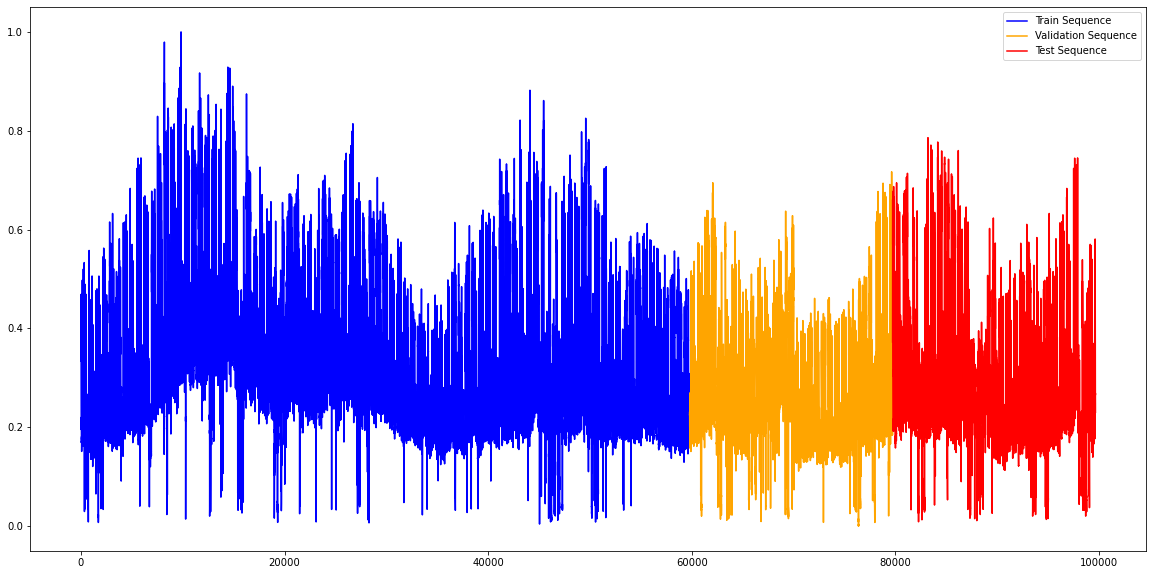

In [8]:
plt.figure(figsize=(20, 10))
plt.plot(train_df['consumption'], color='blue')
plt.plot(val_df['consumption'], color='orange')
plt.plot(test_df['consumption'], color='red')
plt.legend(['Train Sequence', 'Validation Sequence', 'Test Sequence'])

In [9]:
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [10]:
lookback=4*24*14
horizon=4*24*1

In [11]:
def make_windows(data, target_col='consumption', lookback=4*24*14, horizon=4*24*1):
    
    X = np.zeros((len(data)-lookback - horizon + 1, lookback, len(data.columns)))
    y = np.zeros((len(data)-lookback - horizon + 1, horizon, 1))

    for i in tqdm(range(lookback, len(data) - horizon + 1)):  
        X[i-lookback, :, :] = data.iloc[i - lookback: i].values
        y[i-lookback, :, :] = data.iloc[i: i + horizon][target_col].values.reshape(-1, 1)

    return X, y

In [12]:
X_train, y_train = make_windows(train_df)

100%|██████████| 58349/58349 [00:10<00:00, 5711.55it/s]


In [13]:
X_val, y_val = make_windows(val_df)

100%|██████████| 18491/18491 [00:03<00:00, 5493.79it/s]


In [14]:
X_test, y_test = make_windows(test_df)

100%|██████████| 18491/18491 [00:03<00:00, 5495.05it/s]


In [22]:
sgd = tf.keras.optimizers.SGD(lr=1e-2, decay=1e-8, momentum=0.9, nesterov=True)
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5)
loss_funk = tf.keras.losses.MeanSquaredError(reduction='sum_over_batch_size')

In [23]:
batch_size = 256
num_epochs = 100

In [24]:
i = tf.keras.layers.Input((lookback, 9))
x = tf.keras.layers.Conv1D(filters=256, kernel_size=24, activation='relu')(i)
x = tf.keras.layers.MaxPooling1D(pool_size=24)(x)
x = tf.keras.layers.Conv1D(filters=256, kernel_size=24, activation='relu')(x)
x = tf.keras.layers.MaxPooling1D(pool_size=24)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(horizon, activation='relu')(x)

In [25]:
model = tf.keras.models.Model(inputs=i, outputs=x)
model.compile(optimizer = sgd, loss = loss_funk)

In [26]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1344, 9)]         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1321, 256)         55552     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 55, 256)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 32, 256)           1573120   
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 1, 256)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 96)                2467

In [27]:
history = model.fit(X_train, y_train, batch_size = batch_size, epochs = num_epochs, validation_data = (X_val, y_val), callbacks=[earlystop], verbose=1)

Epoch 1/100
228/228 [==============================] - 25s 108ms/step - loss: 0.0572 - val_loss: 0.0372
Epoch 2/100
228/228 [==============================] - 20s 89ms/step - loss: 0.0535 - val_loss: 0.0372
Epoch 3/100
228/228 [==============================] - 20s 90ms/step - loss: 0.0530 - val_loss: 0.0366
Epoch 4/100
228/228 [==============================] - 20s 90ms/step - loss: 0.0517 - val_loss: 0.0357
Epoch 5/100
228/228 [==============================] - 21s 90ms/step - loss: 0.0498 - val_loss: 0.0351
Epoch 6/100
228/228 [==============================] - 20s 87ms/step - loss: 0.0493 - val_loss: 0.0350
Epoch 7/100
228/228 [==============================] - 20s 88ms/step - loss: 0.0492 - val_loss: 0.0351
Epoch 8/100
228/228 [==============================] - 20s 88ms/step - loss: 0.0491 - val_loss: 0.0351
Epoch 9/100
228/228 [==============================] - 20s 88ms/step - loss: 0.0490 - val_loss: 0.0350
Epoch 10/100
228/228 [==============================] - 20s 88ms/step - 

KeyboardInterrupt: 

In [ ]:
model.save('saved_models/cnn_multivariate.hdf5')

In [22]:
#model = tf.keras.models.load_model('saved_models/nbeats_univ.hdf5')

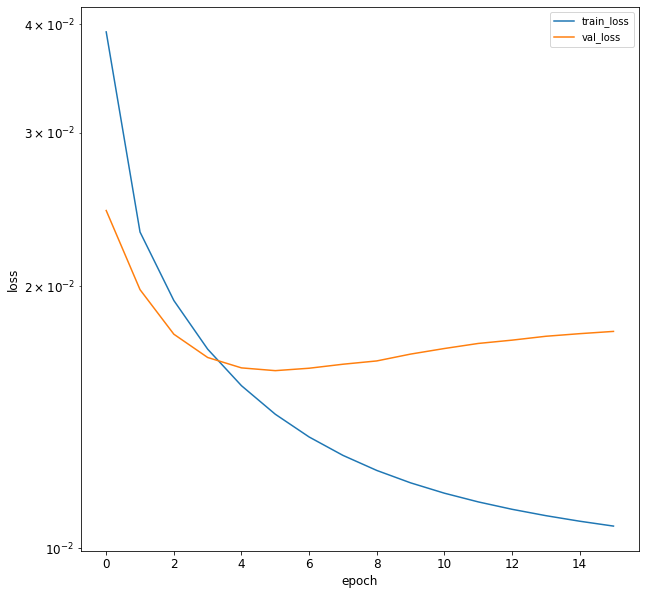

In [28]:
plot_df = po.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(10,10), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
#plt.savefig('forecasts/' + args.save_folder + '/train_val_loss.png')
plt.show()

In [29]:
y_pred = model.predict(X_test)

In [30]:
y_pred = y_pred.squeeze()
y_test = y_test.squeeze()

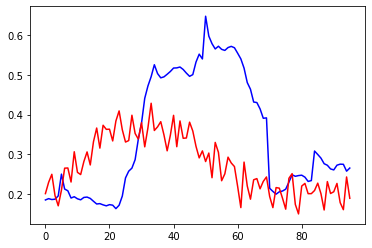

In [31]:
plt.plot(y_test[5251], color = 'blue')
plt.plot(y_pred[5251], color = 'red')
#plt.savefig('forecasts/' + args.save_folder + '/test_1_pred.png')

In [34]:
y_test.shape

(18491, 96)

In [44]:
max_ = scaler.data_max_[0]
min_ = scaler.data_min_[0]

In [47]:
y_pred = y_pred*(max_ - min_) + min_

In [50]:
y_test = y_test*(max_ - min_) + min_

In [51]:
forecasts = []
actuals = []
forecasts_n = []
actuals_n = []
for i in tqdm(range(y_pred.shape[0]//288)): ## we have forecasts for these many complete day
  forecasts += (y_pred[12*24*i].reshape(-1)).tolist()
  actuals += (y_test[12*24*i].reshape(-1, 1)).tolist()
  forecasts_n += y_pred[12*24*i].tolist()
  actuals_n += y_test[12*24*i].tolist()

100%|██████████| 64/64 [00:00<00:00, 20183.12it/s]


In [52]:
df_pred = po.DataFrame()
df_pred['Predictions'] = forecasts
df_pred['Actual Values'] = actuals

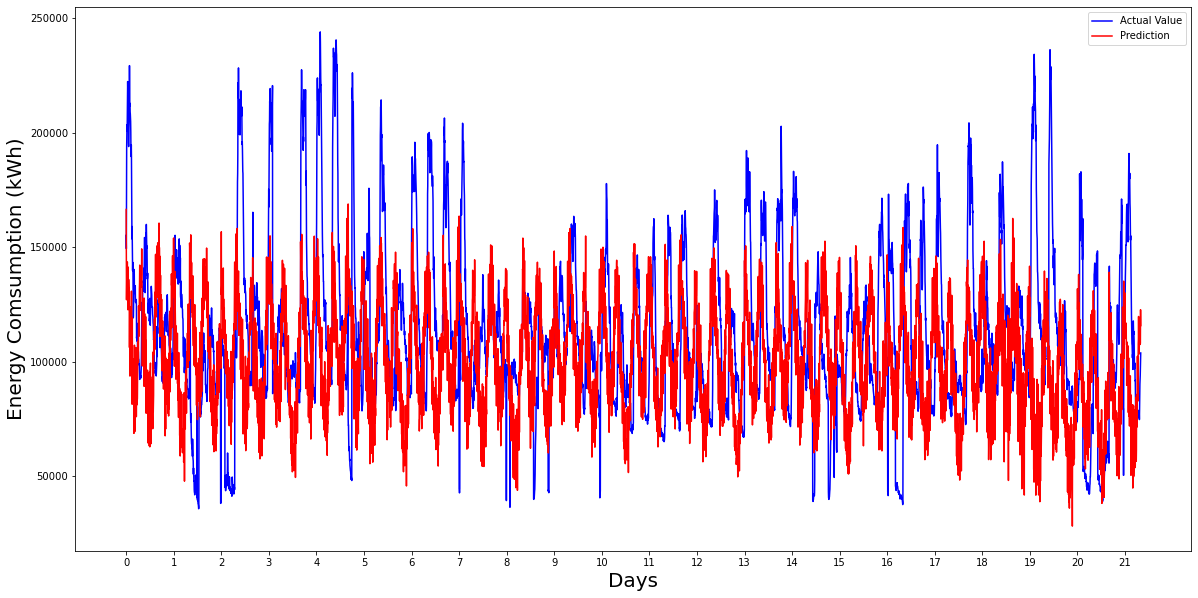

In [53]:
plt.figure(figsize=(20, 10))
plt.xlabel('Days', size = 20)
plt.ylabel('Energy Comsumption (kWh)', size = 20)
plt.xticks(ticks = list(range(0, len(forecasts) + 1, 288)), labels = list(range(0, int(len(forecasts)/288 + 1))), size = 10)
plt.yticks(size = 10)
plt.plot(actuals, color = 'blue')
plt.plot(forecasts, color = 'red')
plt.legend(['Actual Value', 'Prediction'])

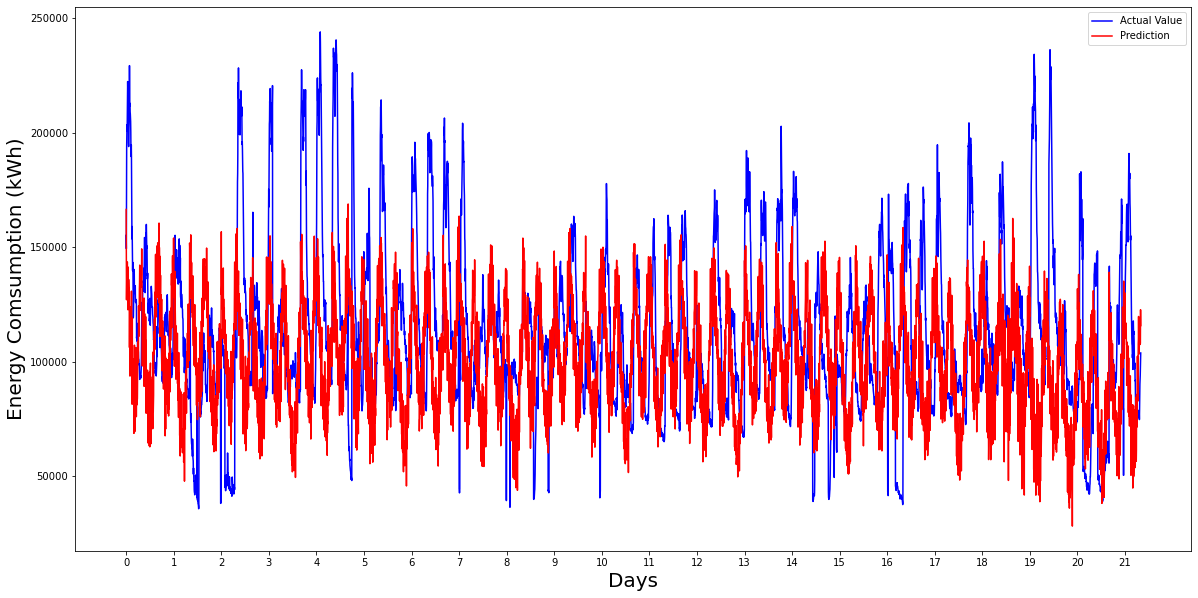

In [54]:
plt.figure(figsize=(20, 10))
plt.xlabel('Days', size = 20)
plt.ylabel('Energy Comsumption (kWh)', size = 20)
plt.xticks(ticks = list(range(0, len(forecasts) + 1, 288)), labels = list(range(0, int(len(forecasts)/288 + 1))), size = 10)
plt.yticks(size = 10)
plt.plot(actuals_n, color = 'blue')
plt.plot(forecasts_n, color = 'red')
plt.legend(['Actual Value', 'Prediction'])

In [55]:
results = po.DataFrame(columns = ['MAE', 'MSE', 'R2'])  
errors = {'MAE': mean_absolute_error(y_true=y_test, y_pred=y_pred),
          'MAPE': mean_absolute_error(y_true=y_test, y_pred=y_pred)*100,
          'MSE': mean_squared_error(y_true=y_test, y_pred=y_pred),
          'RMSE': mean_squared_error(y_true=y_test, y_pred=y_pred, squared=False),
          'R2': r2_score(y_true=y_test, y_pred=y_pred)          
          }
errors = po.Series(errors)
results = results.append(errors, ignore_index=True)
results

,MAE,MSE,R2,MAPE,RMSE
0,33703.861696,1.796027e+09,-0.336223,3.370386e+06,42379.559956
